In [5890]:
#Подключаем библиотеки и скрипты
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5891]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [5892]:
TRAIN_DATASET_PATH = 'project/train.csv'
TEST_DATASET_PATH = 'project/test.csv'

In [5893]:
#Загружаем тренировочный датасет, индекс - колонка Id
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [5894]:
#Загружаем тестовый датасет
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [5895]:
#Проверяем размеры тренировочного и тестового датасетов
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [5896]:
#Анализируем типы данных
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5897]:
#Для работы с DostrictId как с категориальным признаком сделаем его строковым
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

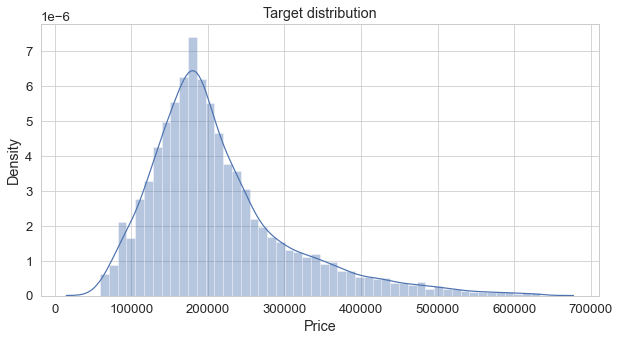

In [5898]:
#Выведем гистограмму целевой переменной
plt.figure(figsize = (10, 5))
sns.distplot(train_df['Price'])
plt.title('Target distribution');

In [5899]:
#Определяем количество уникальных значений по каждому признаку
train_df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [5900]:
#Выведем статистику по количественным признакам
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [5901]:
#Отделяем все количественные признаки в список feature_num_names
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

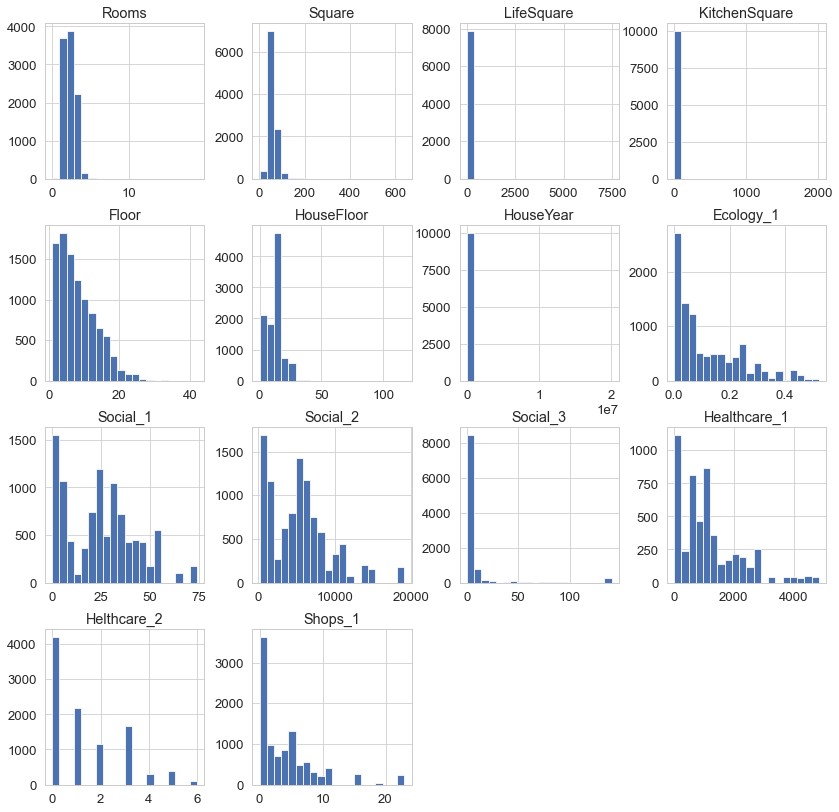

In [5902]:
#Для каждого признака строим гистограмму по цене
train_df[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

In [5903]:
#Отделяем все категориальные признаки в список feature_cat_names
feature_cat_names = train_df.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [5904]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

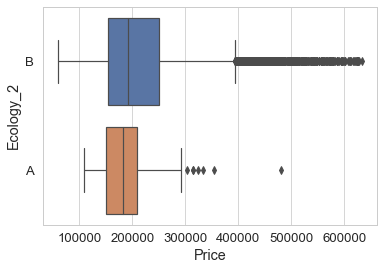

In [5905]:
#Чтобы посмотреть распределение целевой переменной построим boxplot
sns.boxplot('Price', 'Ecology_2', data=train_df);
#Разницы в категориях А и В (относительно медианы) практически нет - возможно признак не влияет на результат (можно убрать)

In [5906]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

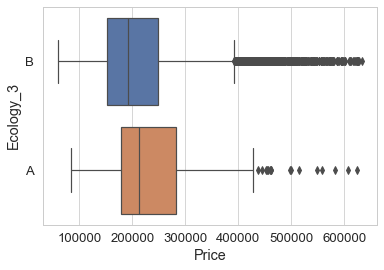

In [5907]:
sns.boxplot('Price', 'Ecology_3', data=train_df);
#Разница тоже не существенная (признак тоже можно убрать)

In [5908]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

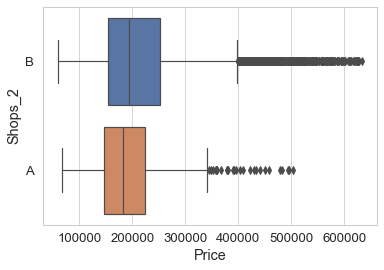

In [5909]:
sns.boxplot('Price', 'Shops_2', data=train_df);
#Разница А и В тоже не велика (признак тоже можно исключить)

In [5910]:
#Так как в признаках 'Ecology_2', 'Ecology_3', 'Shops_2' всего по два значения, то объединим их в новый список feature_bin_names
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

#Заменяем в тренировочном и тестовом датасетах в этих трех признаках с А на 0, с В на 1
train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

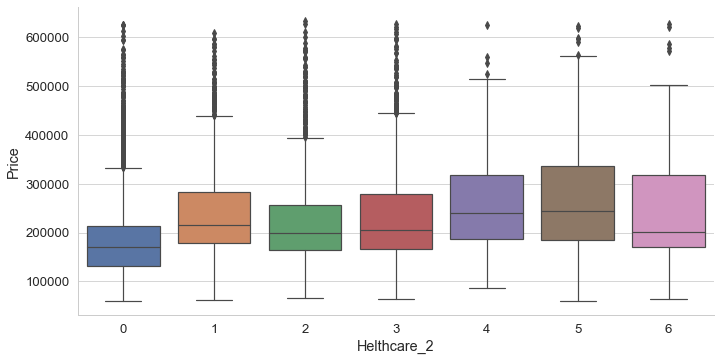

In [5911]:
#Построим график для признака Helthcare_2
sns.catplot('Helthcare_2', 'Price', kind="box", data=train_df, aspect=2/1);

In [5912]:
#Судя по катплоту значения Helthcare_2 можно сгруппировать в три группы: 0; 1-2-3-6; 4-5
#Это позволило увеличить метрику на 0,2
train_df['Helthcare_2'] = train_df['Helthcare_2'].replace({1:11, 2:11, 3:11, 6:11, 4:22, 5:22})
test_df['Helthcare_2'] = test_df['Helthcare_2'].replace({1:11, 2:11, 3:11, 6:11, 4:22, 5:22})

In [5913]:
#ОБРАБОТКА ПРОПУСКОВ

#Определяем, какие признаки имеют пропуски
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [5914]:
#Заменяем пропуски в признаке жилая площадь (LifeSquare) на разность общей площади (Square) и площади кухни (KitchenSquare)
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']
train_df.isna().sum()[train_df.isna().sum() != 0]

Healthcare_1    4798
dtype: int64

In [5915]:
#Заменяем пропуски в Healthcare_1 средним значением по признаку Helthcare_2
pd.concat([train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].count(),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Helthcare_2,,,,
0,"1,007.78",913.61,1275,2939
11,"1,084.96",960.85,3427,1683
22,"1,884.65","1,333.57",500,176


In [5916]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [5917]:
#Обработаем аномальные значения по признаку Rooms - есть 4 аномальных значения
train_df['Rooms'].value_counts()
#train_df[train_df['Price']<100000].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
6.00        1
19.00       1
Name: Rooms, dtype: int64

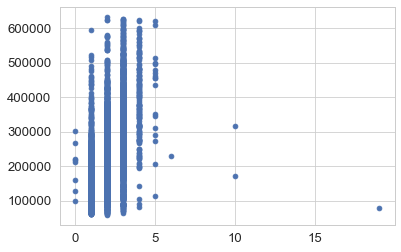

In [5918]:
#Выведем зависимость цены от количества комнат
plt.scatter(train_df['Rooms'], train_df['Price']);

In [5919]:
#Ищем аномальные значения по количеству комнат
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

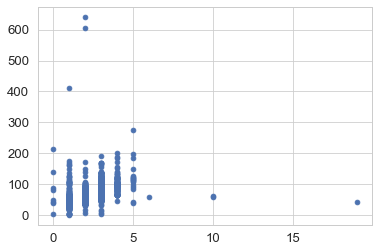

In [5920]:
#Выведем зависимость площади от количества комнат
plt.scatter(train_df['Rooms'], train_df['Square']);

In [5921]:
#Рассчитаем наиболее часто встречающееся значение для признака Rooms
train_df['Rooms'].mode()[0]

2.0

In [5922]:
#Заменим комнаты, где площадь аномальная, наиболее часто встречающимся значением - .mode()[0]
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] # !!

In [5923]:
#Обработаем аномальные значения по признакам Rooms Square, LifeSquare, KitchenSquare
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,41.80,6.27
std,21.06,77.82,28.56
min,1.14,0.37,0.00
25%,41.77,25.49,1.00
50%,52.51,37.04,6.00
75%,65.90,49.82,9.00
max,641.07,"7,480.59","2,014.00"


In [5924]:
#Ищем аномальные значения по площади кухни
train_df['KitchenSquare'].value_counts()

1.00     2460
8.00     1306
5.00     1169
10.00    1075
6.00     1038
         ... 
36.00       1
53.00       1
96.00       1
62.00       1
75.00       1
Name: KitchenSquare, Length: 58, dtype: int64

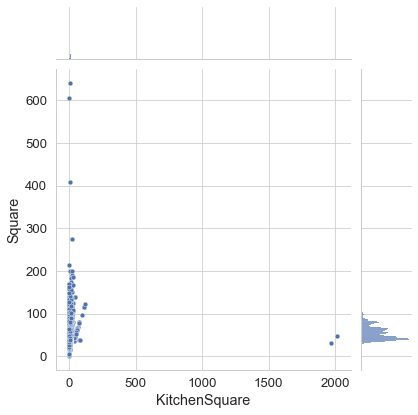

In [5925]:
#Поищем визуально аномальные квартиры с точки зрения KitchenSquare
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind='scatter', height=6);

In [5926]:
#Выведем аномальные значения для кухни
train_df.loc[(train_df['KitchenSquare'] > 150) | (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,"1,007.78",0,0,0,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,1,1,21,5731,0,"1,084.96",11,0,1,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,"1,007.78",0,0,1,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,645.00,11,6,1,"105,539.56"


In [5927]:
#Рассчитаем медиану для KitchenSquare
train_df['KitchenSquare'].median()

6.0

In [5928]:
#Заменяем аномальные значения KitchenSquare на медиану
train_df.loc[(train_df['KitchenSquare'] > 150) | (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 150) | (test_df['KitchenSquare'] > test_df['Square']),
            'KitchenSquare'] = train_df['KitchenSquare'].median()

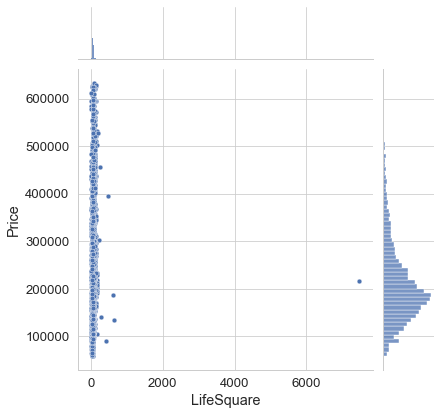

In [5929]:
#Поищем визуально аномальные квартиры с точки зрения LifeSquare
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='scatter', height=6);

In [5930]:
#Заменим аномальные квартиры по признаку LifeSquare в обоих наборах на медиану
train_df.loc[(train_df['LifeSquare'] > 400), 'LifeSquare'] = train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare'] > 400), 'LifeSquare'] = train_df['LifeSquare'].median()

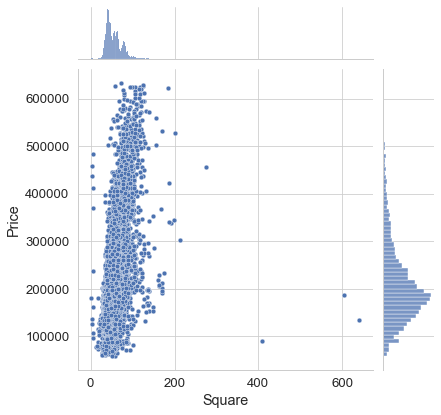

In [5931]:
#Поищем визуально аномальные квартиры с точки зрения Square
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

In [5932]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,"1,084.96",11,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,"1,007.78",0,0,1,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,"1,007.78",0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,"2,643.00",22,5,1,"369,472.40"
28,9,2.00,604.71,37.04,1.00,17,18.00,1977,0.16,1,1,25,5648,1,30.00,11,4,1,"187,717.24"
2307,102,1.00,409.43,37.04,10.00,4,4.00,2016,0.24,1,1,26,3889,6,705.00,11,6,1,"90,470.43"
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,"1,007.78",0,0,1,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,1,1,9,1892,0,"1,007.78",0,1,1,"161,379.07"


In [5933]:
#Заменяем комнаты с аномальной общей площадью на медиану
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = train_df['Square'].median()
test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = train_df['Square'].median()

In [5934]:
#Определяем количество квартир, где общая площадь меньше, чем сумма площадей кухни и жилой (таких много)
len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

830

In [5935]:
train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23"
8054,23,1.00,42.53,43.97,1.00,3,9.00,2014,0.03,1,1,0,168,0,"1,007.78",0,0,1,"95,338.20"
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,1,1,15,2787,2,520.00,0,7,1,"435,462.05"
7596,23,1.00,47.08,46.81,12.00,3,9.00,1977,0.01,1,1,2,475,0,"1,007.78",0,0,1,"96,029.17"
2301,1,2.00,61.40,65.22,0.00,17,22.00,2016,0.01,1,1,1,264,0,"1,007.78",0,1,1,"199,215.45"


In [5936]:
#Откорректируем жилую площадь разностью между общей площадью и площадью кухни
train_df.loc[(train_df['LifeSquare'] < 5), 'LifeSquare'] = \
    train_df['Square'] - train_df['KitchenSquare']

test_df.loc[(test_df['LifeSquare'] < 5), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

In [5937]:
#Результат после чистки
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,41.76,5.86
std,19.06,20.25,5.07
min,13.78,0.19,0.00
25%,41.79,27.22,1.00
50%,52.51,37.98,6.00
75%,65.89,50.65,9.00
max,275.65,263.54,123.00


In [5938]:
#Выведем этажность домов
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [5939]:
#Выведем этажи в квартирах
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

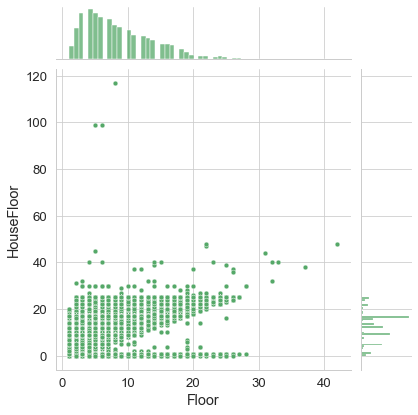

In [5940]:
#Поищем визуально аномальные квартиры с точки зрения этажа квартиры и этажности дома
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=6, color='g');

In [5941]:
#Заменяем дома с аномальной этажностью на наиболее часто встречающуюся этажность
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 98), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[(test_df['HouseFloor'] == 0) | (test_df['HouseFloor'] > 98), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [5942]:
#Определяем индексы квартир, у которых этаж выше этажности дома
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [5943]:
#Заменяем Floor случайными значениями у обоих наборов у квартир, у которых этаж выше этажности дома
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [5944]:
#Выведем года постройки домов
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
8892         2020
3445         2020
6731         2020
           ...   
7920         1916
6751         1914
14556        1912
2085         1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [5945]:
#Заменим год постройки дома, который старше 2020 года, на 2011
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011

In [5946]:
#Определим количество квартир в каждом районе
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,117,1
202,209,1
203,174,1


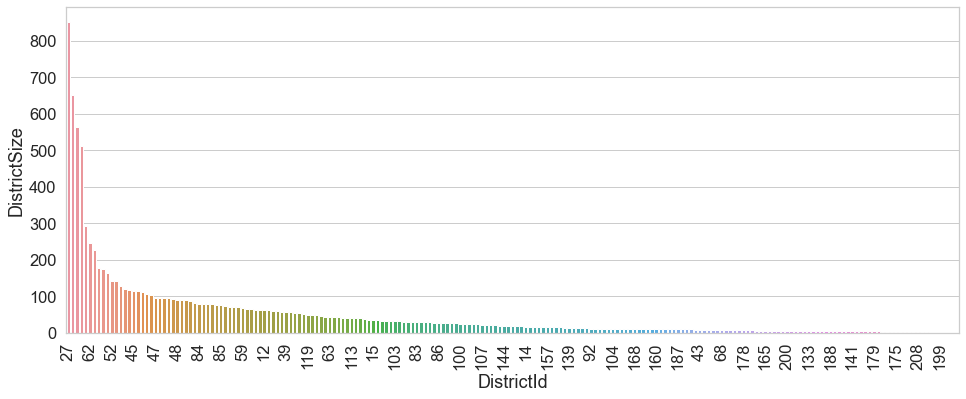

In [5947]:
#Построим зависимость количества квартир от района
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [5948]:
#Выведем районы с количеством квартир больше 100
district_size.loc[district_size['DistrictSize'] > 100, :]

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [5949]:
#Формируем список наиболее популярных районов
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

In [5950]:
#Если район не популярный, то присваиваем новое значение 999 (чтобы метить как непопулярный)
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
#Рассчитаем среднее количество квартир в непопулярных районах
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,999,15
1,1,652
2,11,129
3,21,165
4,23,565
5,27,851
6,30,228
7,34,111
8,44,104
9,45,116


In [5951]:
#Переопределяем в обоих наборах непопулярные районы как 999
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [5952]:
#Выведем количество квартир в каждом районе
test_df['DistrictId'].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
61       64
8        64
74       61
46       61
34       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

In [5953]:
#Построим новые признаки

#Добавим в тренировочный и тестовый наборы новый признак district_size 
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,"1,007.78",0,11,1,"184,966.93",15
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,11,16,1,"300,009.45",15
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,11,3,1,"220,925.91",174
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23",179
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",11,4,1,"150,226.53",15


In [5954]:
#Делаем еще один признак PriceOneRoom
train_df['PriceOneRoom'] = train_df['Price'] / train_df['Rooms']

In [5955]:
#Посмотрим результаты
train_df['PriceOneRoom'].describe()

count    10,000.00
mean    124,245.13
std      50,723.97
min      20,585.69
25%      89,449.16
50%     114,961.11
75%     152,997.53
max     594,565.30
Name: PriceOneRoom, dtype: float64

In [5956]:
#Чтобы добавить признак PriceOneRoom в тестовый датасет, сделаем признак price_by_district
price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'PriceOneRoom':'median'}).rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})
price_by_district

,DistrictId,PriceOneRoomByDistrict
0,999,"129,339.27"
1,1,"106,080.90"
2,11,"100,098.98"
3,21,"104,448.25"
4,23,"76,232.42"
5,27,"94,738.78"
6,30,"93,960.73"
7,34,"129,738.65"
8,44,"125,925.66"
9,45,"164,907.84"


In [5957]:
#Добавляем датасет price_by_district в оба набора
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [5958]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,PriceOneRoom,PriceOneRoomByDistrict
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,...,7976,5,"1,007.78",0,11,1,"184,966.93",15,"92,483.47","129,339.27"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,...,10309,1,240.00,11,16,1,"300,009.45",15,"100,003.15","129,339.27"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,...,7759,0,229.00,11,3,1,"220,925.91",174,"110,462.95","138,669.20"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,...,5735,3,"1,084.00",0,5,1,"175,616.23",179,"87,808.11","105,638.52"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,...,5776,1,"2,078.00",11,4,1,"150,226.53",15,"150,226.53","129,339.27"


In [5959]:
#Добавим новый признак Площадь комнаты RoomSquare
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

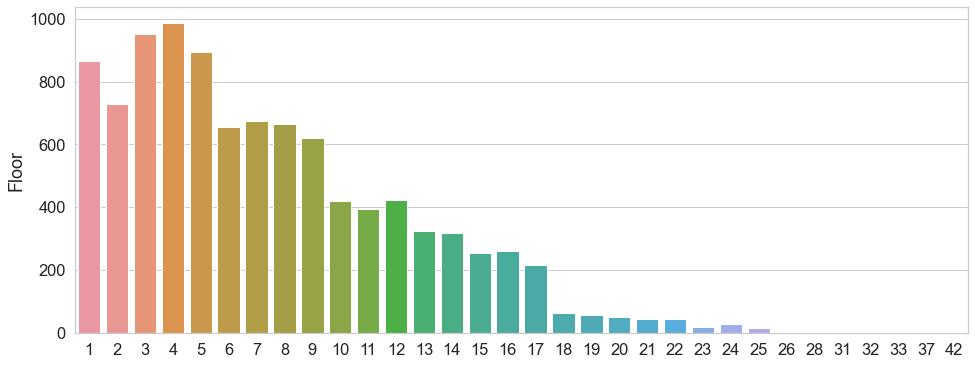

In [5960]:
#Выведем график зависимости количества квартир от этажа
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['Floor'].value_counts(), x=train_df['Floor'].value_counts().index);

In [5961]:
#Добавим новый КАТЕГОРИАЛЬНЫЙ признак Floor_cat на основе числового
#Разобьем этажи на 3 категории в обоих наборах
train_df.loc[train_df['Floor'] <= 5, 'Floor_cat'] = 1  
train_df.loc[(train_df['Floor'] > 5) & (train_df['Floor'] <= 17), 'Floor_cat'] = 2
train_df.loc[train_df['Floor'] > 17, 'Floor_cat'] = 3

test_df.loc[test_df['Floor'] <= 5, 'Floor_cat'] = 1  
test_df.loc[(test_df['Floor'] > 5) & (test_df['Floor'] <= 17), 'Floor_cat'] = 2
test_df.loc[test_df['Floor'] > 17, 'Floor_cat'] = 3

train_df['Floor_cat'].value_counts()

2.00    5237
1.00    4426
3.00     337
Name: Floor_cat, dtype: int64

In [5962]:
#Вариант разбиения на квартили, признак Floor_cat_qcut
labels = [1, 2, 3]
train_df['Floor_cat_qcut'] = pd.qcut(train_df['Floor'], q=3, labels=labels)
test_df['Floor_cat_qcut'] = pd.qcut(test_df['Floor'], q=3, labels=labels)
train_df['Floor_cat_qcut'].value_counts()

1    3531
2    3512
3    2957
Name: Floor_cat_qcut, dtype: int64

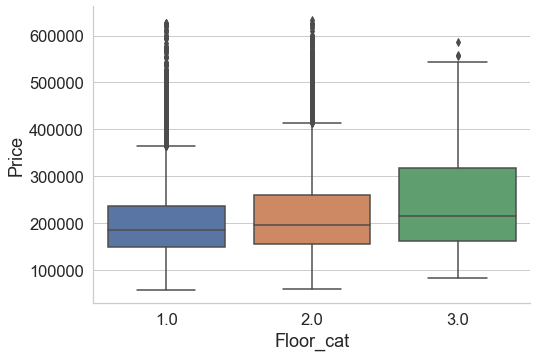

In [5963]:
sns.catplot("Floor_cat", "Price", kind="box", data=train_df, aspect=3/2);
#Новый признак почти не влияет на цену

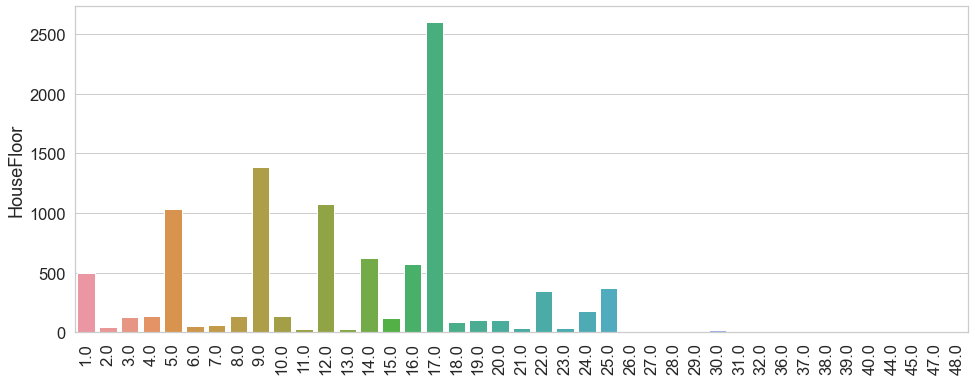

In [5964]:
#Выведем график зависимости количества квартир от 'этажности дома
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), x=train_df['HouseFloor'].value_counts().index,
#           order=train_df['HouseFloor'].value_counts().index
           );
ax.tick_params(axis='x', rotation=90)

In [5965]:
#Добавим новый КАТЕГОРИАЛЬНЫЙ признак HouseFloor_cat на основе числового
#Разобьем этажность на 3 категории в обоих наборах
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
train_df.loc[train_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
test_df.loc[test_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

train_df['HouseFloor_cat'].value_counts()

2.00    6838
1.00    1837
3.00    1325
Name: HouseFloor_cat, dtype: int64

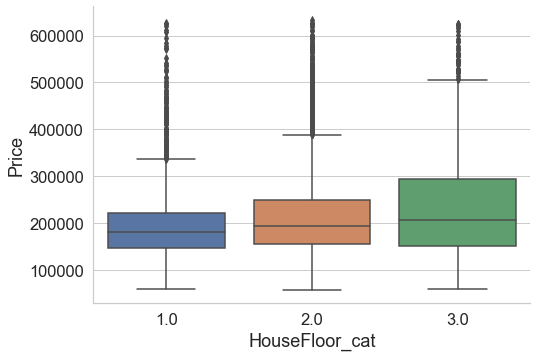

In [5966]:
sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=3/2);
#Признак также не сильно влияет на цену

In [5967]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

In [5968]:
train_df.dtypes

DistrictId                  object
Rooms                      float64
Square                     float64
LifeSquare                 float64
KitchenSquare              float64
Floor                        int64
HouseFloor                 float64
HouseYear                    int64
Ecology_1                  float64
Ecology_2                    int64
Ecology_3                    int64
Social_1                     int64
Social_2                     int64
Social_3                     int64
Healthcare_1               float64
Helthcare_2                  int64
Shops_1                      int64
Shops_2                      int64
Price                      float64
DistrictSize                 int64
PriceOneRoom               float64
PriceOneRoomByDistrict     float64
RoomSquare                 float64
Floor_cat                    int32
Floor_cat_qcut            category
HouseFloor_cat               int32
dtype: object

In [5969]:
#Отбор признаков

#Выгружаем обработанные тренировочный и тестовый наборы в .csv
train_df.to_csv('project/train_prepared.csv')
test_df.to_csv('project/test_prepared.csv')

In [5970]:
#Сформируем список признаков
feature_names = train_df.columns
feature_names.tolist()
feature_names = list(feature_names)
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'PriceOneRoom',
 'PriceOneRoomByDistrict',
 'RoomSquare',
 'Floor_cat',
 'Floor_cat_qcut',
 'HouseFloor_cat']

In [5971]:
#Сформируем список всех признаков, кроме 'Price', 'PriceOneRoom' (на них не обучаем)
feature_names_full = [feature for feature in feature_names if feature not in ['Price', 'PriceOneRoom']]
len(feature_names_full)

24

In [5972]:
#Отбор признаков методом RFE
#Для отбора значимых признаков используется метод рекурсивного исключения признаков (recursive feature elimination, RFE).
#Сущность метода: модель обучается на всех признаках и оценивается их значимость.
#Затем исключается один или несколько наименее значимых признаков. Модель снова обучается на оставшихся признаках,
# снова их оценивает и так далее, пока не останется заданное количество лучших признаков
X_full = train_df[feature_names_full]
len(feature_names_full)

24

In [5973]:
target_name = ['Price']
feature_names = ['Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'RoomSquare',
 'HouseFloor_cat']

In [5974]:
#Получаем набор наиболее важных признаков
from sklearn.feature_selection import RFE

rfe = RFE(estimator=forest, 
          n_features_to_select=16,
          step=2)

rfe.fit(X_full, y)
X_full.columns[rfe.support_]

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Shops_1', 'DistrictSize', 'PriceOneRoomByDistrict',
       'RoomSquare'],
      dtype='object')

In [5975]:
X_new = rfe.transform(X_full)
scores = cross_val_score(forest, X_new, y, scoring='r2', cv=kf)
print('R2: %.5f' % scores.mean())

R2: 0.73223


In [5976]:
#Определяем оптимальное количество признаков, которое нужно оставить (от 16 до 24)
#for n in range(16, 24, 1):
#    rfe = RFE(forest, n_features_to_select=n, step=2)
#    X_new = rfe.fit_transform(X_full, y)
#    scores = cross_val_score(forest, X_new, y, scoring='r2', cv=kf)
#    print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean())) 

In [5977]:
#Настройка гиперпараметров
params = {
#    'n_estimators': [100],
    'max_depth': [15,16,17],
    'max_features': [2,3,4]
}

In [5978]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=5, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) 

{'max_depth': 16, 'max_features': 3}
R2 на train: 0.73993


In [5979]:
#Прогнозирование на тестовом датасете
# forest_best = forest_grid.best_estimator_
forest_best = RandomForestRegressor(max_depth=16,
                                    max_features=3,
                                    random_state=42)
forest_best.fit(X, y)
y_pred = forest_best.predict(test_df[feature_names])
y_pred

array([163067.16383275, 228845.565722  , 248836.04723584, ...,
       333349.7114918 , 194938.14649957, 175890.14371143])

In [5980]:
#Записываем предсказания в датафрейм
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"163,067.16"
1,15856,"228,845.57"
2,5480,"248,836.05"
3,15664,"339,485.01"
4,14275,"148,942.82"


In [5981]:
#Выгружаем результат в .csv
preds.to_csv('project/KMarenin_predictions.csv', index=False)